In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [4]:
def wrangle(filepath):
    # Read the csv file into DataFrame
    df = pd.read_csv(filepath).set_index("Patient_ID")
    
    # Identify leaky columns and drop
    df.drop(columns="Heart_Attack_History",inplace = True)
    
    return df

In [5]:
df = wrangle("resources/heart_attack_south_africa.csv")
df.head()

,Age,Gender,Cholesterol_Level,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Smoking_Status,Alcohol_Intake,Physical_Activity,Obesity_Index,Diabetes_Status,Family_History_Heart_Disease,Diet_Quality,Stress_Level,Medication_Usage,Triglycerides_Level,LDL_Level,HDL_Level,Heart_Attack_Outcome
Patient_ID,,,,,,,,,,,,,,,,,,
1,76,Female,156,94,79,No,High,Sedentary,35.2,No,No,Good,High,No,264,141,65,0
2,39,Female,160,185,88,No,Low,Sedentary,21.3,No,No,Average,Medium,Yes,150,81,42,0
3,85,Male,254,173,113,Yes,Moderate,Highly Active,32.0,Yes,No,Good,Low,No,220,124,70,1
4,45,Female,261,187,65,No,High,Sedentary,36.4,No,Yes,Average,Low,Yes,141,56,38,1
5,48,Male,206,189,84,No,Low,Active,26.6,No,No,Good,High,No,221,186,26,0


In [6]:
# see the size of data
df.shape

(100000, 18)

In [7]:
# Checking for null values and data type of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 1 to 100000
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Age                           100000 non-null  int64  
 1   Gender                        100000 non-null  object 
 2   Cholesterol_Level             100000 non-null  int64  
 3   Blood_Pressure_Systolic       100000 non-null  int64  
 4   Blood_Pressure_Diastolic      100000 non-null  int64  
 5   Smoking_Status                100000 non-null  object 
 6   Alcohol_Intake                100000 non-null  object 
 7   Physical_Activity             100000 non-null  object 
 8   Obesity_Index                 100000 non-null  float64
 9   Diabetes_Status               100000 non-null  object 
 10  Family_History_Heart_Disease  100000 non-null  object 
 11  Diet_Quality                  100000 non-null  object 
 12  Stress_Level                  100000 non-null  ob

In [8]:
obj_col = [obj for obj in df.select_dtypes("object")]
obj_col

['Gender',
 'Smoking_Status',
 'Alcohol_Intake',
 'Physical_Activity',
 'Diabetes_Status',
 'Family_History_Heart_Disease',
 'Diet_Quality',
 'Stress_Level',
 'Medication_Usage']

In [9]:
# for objects in obj_col:
#     print(df[objects].unique())
#     print("\n")

In [10]:
# Iterate through each object column to analyze its relationship with heart attack outcome
for objects in obj_col:
    objects_pivot = pd.pivot_table(
       df, index = objects, values = "Heart_Attack_Outcome",aggfunc = "mean"
    ).sort_values("Heart_Attack_Outcome")
    print(objects_pivot)

        Heart_Attack_Outcome
Gender                      
Male                0.586792
Female              0.587844
                Heart_Attack_Outcome
Smoking_Status                      
No                          0.490920
Yes                         0.812136
                Heart_Attack_Outcome
Alcohol_Intake                      
Moderate                    0.586161
Low                         0.587071
High                        0.590153
                   Heart_Attack_Outcome
Physical_Activity                      
Highly Active                  0.584836
Active                         0.586783
Sedentary                      0.588623
                 Heart_Attack_Outcome
Diabetes_Status                      
No                           0.525894
Yes                          0.835425
                              Heart_Attack_Outcome
Family_History_Heart_Disease                      
No                                        0.508009
Yes                                       0.82

In [11]:
for objects in obj_col:
    print(df[objects].describe())
    print("\n")

count     100000
unique         2
top       Female
freq       50180
Name: Gender, dtype: object


count     100000
unique         2
top           No
freq       69989
Name: Smoking_Status, dtype: object


count       100000
unique           3
top       Moderate
freq         40262
Name: Alcohol_Intake, dtype: object


count        100000
unique            3
top       Sedentary
freq          50275
Name: Physical_Activity, dtype: object


count     100000
unique         2
top           No
freq       80155
Name: Diabetes_Status, dtype: object


count     100000
unique         2
top           No
freq       74977
Name: Family_History_Heart_Disease, dtype: object


count      100000
unique          3
top       Average
freq        49818
Name: Diet_Quality, dtype: object


count     100000
unique         3
top       Medium
freq       50156
Name: Stress_Level, dtype: object


count     100000
unique         2
top          Yes
freq       50079
Name: Medication_Usage, dtype: object




In [12]:
# List of numerical colomns for correalation and boxplot
num_col = [int for int in df.select_dtypes("number")]
num_col.remove("Heart_Attack_Outcome")
num_col

['Age',
 'Cholesterol_Level',
 'Blood_Pressure_Systolic',
 'Blood_Pressure_Diastolic',
 'Obesity_Index',
 'Triglycerides_Level',
 'LDL_Level',
 'HDL_Level']

<Axes: >

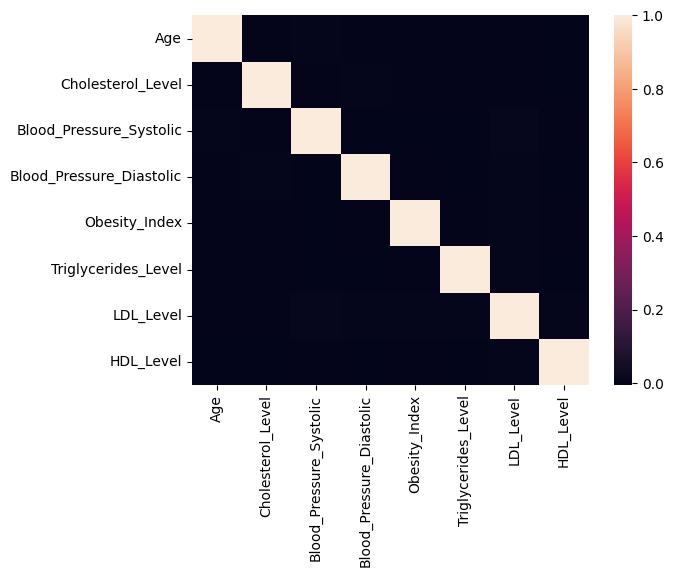

In [13]:
# check for Multicollinearity
correlation = df.drop(columns="Heart_Attack_Outcome").select_dtypes("number").corr()
sns.heatmap(correlation)

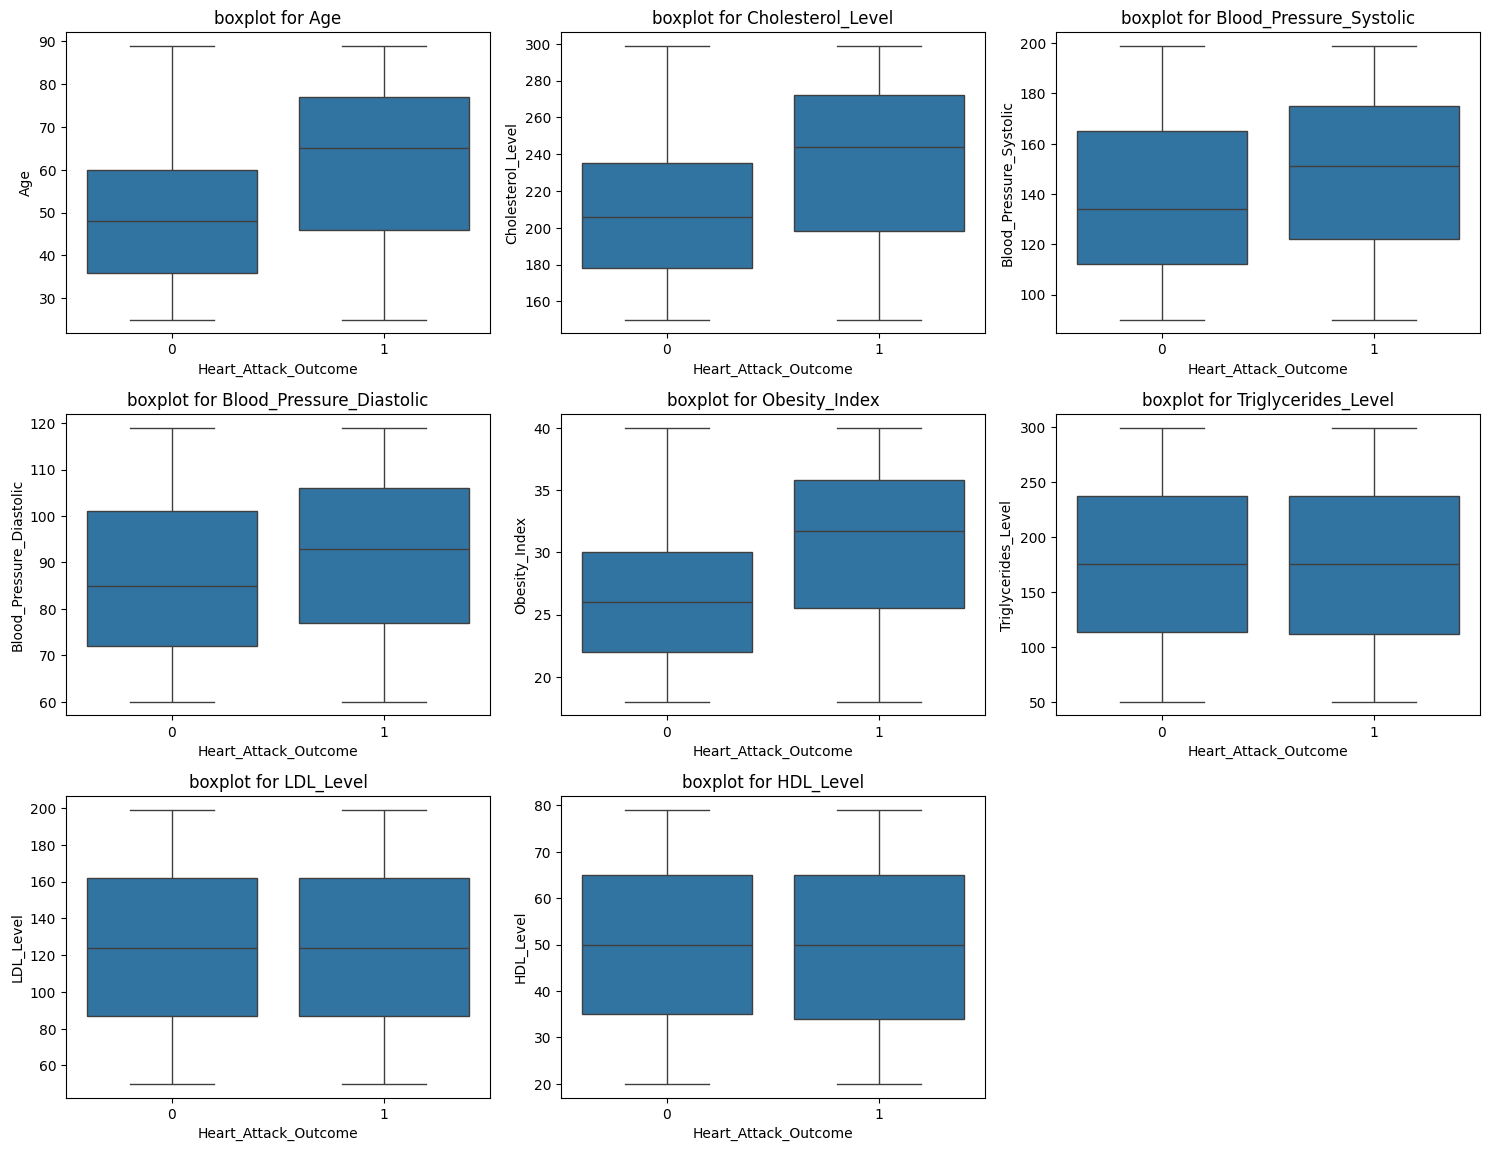

In [14]:
# Set figure size
plt.figure(figsize=(15,15))
# iterate through numrerical col and Create boxplots for each numerical column
for i, col in enumerate (num_col,1):
    plt.subplot(4,3,i)
    sns.boxplot(x="Heart_Attack_Outcome",y = col,data=df)
    plt.title(f"boxplot for {col}")
plt.tight_layout()
plt.show()

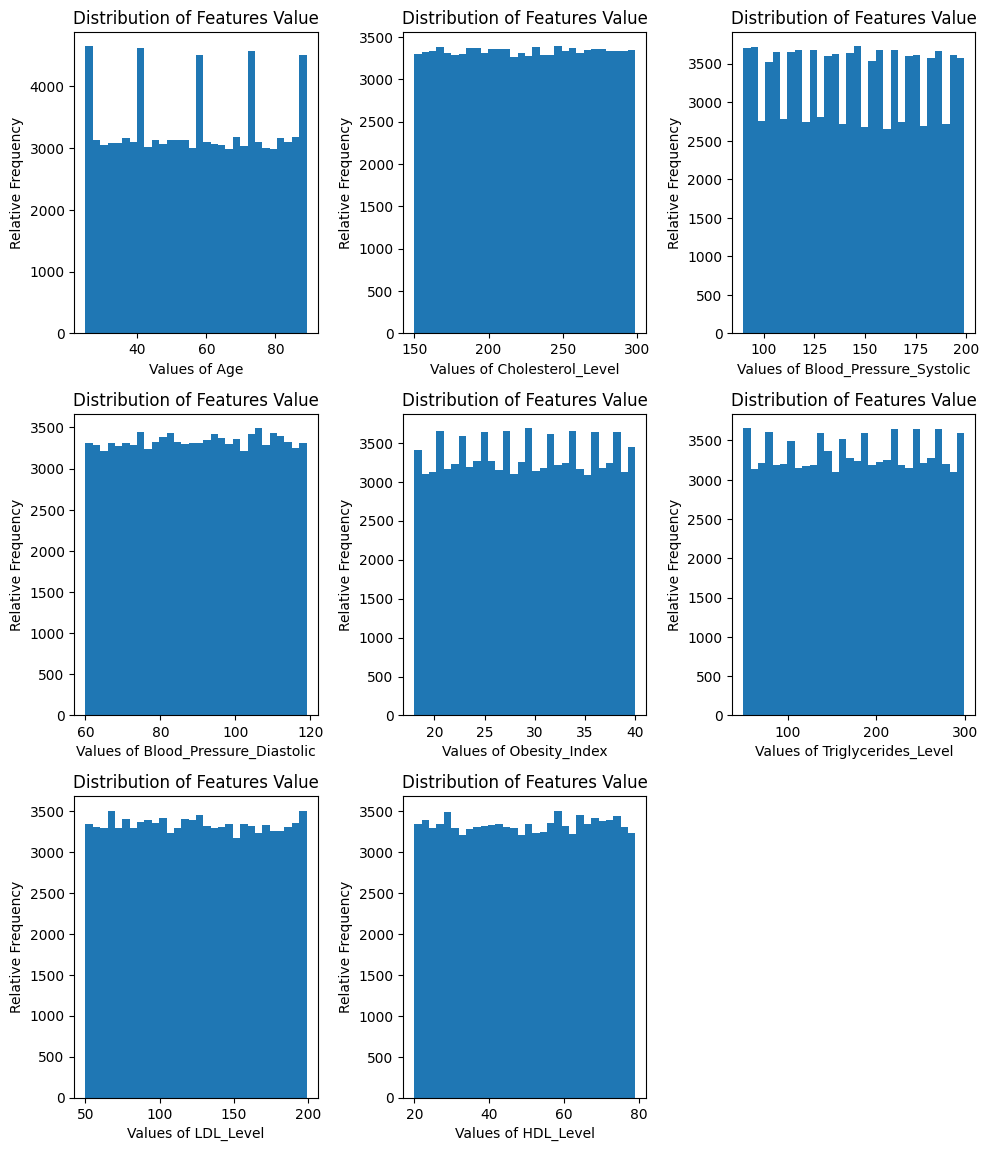

In [15]:
# Set figure size
figure = plt.figure(figsize=(10,15))
# plot histogram to see frequency and check for outliers
for i, column in enumerate(num_col,1):
    plt.subplot(4,3,i)
    plt.hist(df[column],bins=30)
    plt.xlabel(f"Values of {column}")
    plt.ylabel("Relative Frequency")
    plt.title("Distribution of Features Value") 
plt.tight_layout()
plt.show()

In [16]:
# Check for target class imbalance
df["Heart_Attack_Outcome"].value_counts(normalize=True)

Heart_Attack_Outcome
1    0.58732
0    0.41268
Name: proportion, dtype: float64

In [17]:
# Split data into feature metrix and target vector
target = "Heart_Attack_Outcome"
X = df.drop(columns=target)
y = df[target]

In [18]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y , test_size = 0.2, random_state = 42
)
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_test shape:",X_test.shape)
print("X_test shape:",y_test.shape)

X_train shape: (80000, 17)
y_train shape: (80000,)
X_test shape: (20000, 17)
X_test shape: (20000,)


In [19]:
# BUILDING A MODEL
# basaline
acc_baseline = df["Heart_Attack_Outcome"].value_counts(normalize=True).max()
print("Baseline Acc:",round(acc_baseline,2))

Baseline Acc: 0.59


In [20]:
# iterate 
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=3000)
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Smoking_Status',
                                     'Alcohol_Intake', 'Physical_Activity',
                                     'Diabetes_Status',
                                     'Family_History_Heart_Disease',
                                     'Diet_Quality', 'Stress_Level',
                                     'Medication_Usage'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=3000))])

In [21]:
# evaluate
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)
print("Training Accuracy:",round(acc_train,2))
print("Test Accuracy:", round(acc_test,2))

Training Accuracy: 0.88
Test Accuracy: 0.87


In [22]:
# Check the prediction values
model.predict(X_train)[:5]

array([0, 1, 0, 1, 0], dtype=int64)

In [23]:
# see the the probablity of prediction values
model.predict_proba(X_train).round(2)[:5]

array([[1.  , 0.  ],
       [0.4 , 0.6 ],
       [0.73, 0.27],
       [0.01, 0.99],
       [0.55, 0.45]])

In [24]:
# COMMUNICATION 
features = model.named_steps["onehotencoder"].get_feature_names_out()
importances = model.named_steps["logisticregression"].coef_[0]

In [25]:
features

array(['Age', 'Gender_Female', 'Gender_Male', 'Cholesterol_Level',
       'Blood_Pressure_Systolic', 'Blood_Pressure_Diastolic',
       'Smoking_Status_No', 'Smoking_Status_Yes',
       'Alcohol_Intake_Moderate', 'Alcohol_Intake_Low',
       'Alcohol_Intake_High', 'Physical_Activity_Active',
       'Physical_Activity_Sedentary', 'Physical_Activity_Highly Active',
       'Obesity_Index', 'Diabetes_Status_No', 'Diabetes_Status_Yes',
       'Family_History_Heart_Disease_No',
       'Family_History_Heart_Disease_Yes', 'Diet_Quality_Poor',
       'Diet_Quality_Average', 'Diet_Quality_Good', 'Stress_Level_High',
       'Stress_Level_Medium', 'Stress_Level_Low', 'Medication_Usage_Yes',
       'Medication_Usage_No', 'Triglycerides_Level', 'LDL_Level',
       'HDL_Level'], dtype=object)

In [26]:
importances

array([ 8.98884902e-02, -2.61560556e+00, -2.59558672e+00,  3.72686523e-02,
        2.77752245e-02,  4.62538892e-02, -4.54314724e+00, -6.68045037e-01,
       -1.73140300e+00, -1.73808983e+00, -1.74169945e+00, -1.73774456e+00,
       -1.73717302e+00, -1.73627471e+00,  2.64964787e-01, -4.55796587e+00,
       -6.53226405e-01, -4.54909070e+00, -6.62101578e-01, -1.71705201e+00,
       -1.72950040e+00, -1.76463987e+00, -1.74581942e+00, -1.74679343e+00,
       -1.71857943e+00, -2.57518807e+00, -2.63600421e+00, -1.26809064e-04,
       -2.42331515e-05,  2.56673020e-04])

In [27]:
df.head()

,Age,Gender,Cholesterol_Level,Blood_Pressure_Systolic,Blood_Pressure_Diastolic,Smoking_Status,Alcohol_Intake,Physical_Activity,Obesity_Index,Diabetes_Status,Family_History_Heart_Disease,Diet_Quality,Stress_Level,Medication_Usage,Triglycerides_Level,LDL_Level,HDL_Level,Heart_Attack_Outcome
Patient_ID,,,,,,,,,,,,,,,,,,
1,76,Female,156,94,79,No,High,Sedentary,35.2,No,No,Good,High,No,264,141,65,0
2,39,Female,160,185,88,No,Low,Sedentary,21.3,No,No,Average,Medium,Yes,150,81,42,0
3,85,Male,254,173,113,Yes,Moderate,Highly Active,32.0,Yes,No,Good,Low,No,220,124,70,1
4,45,Female,261,187,65,No,High,Sedentary,36.4,No,Yes,Average,Low,Yes,141,56,38,1
5,48,Male,206,189,84,No,Low,Active,26.6,No,No,Good,High,No,221,186,26,0


In [28]:
df.shape

(100000, 18)

In [29]:
# Create Odds Ration 
odds_ratio = pd.Series(np.exp(importances), index = features).sort_values()
odds_ratio.head(12)

Diabetes_Status_No                 0.010483
Family_History_Heart_Disease_No    0.010577
Smoking_Status_No                  0.010640
Medication_Usage_No                0.071647
Gender_Female                      0.073123
Gender_Male                        0.074602
Medication_Usage_Yes               0.076140
Diet_Quality_Good                  0.171248
Stress_Level_Medium                0.174332
Stress_Level_High                  0.174502
Alcohol_Intake_High                0.175222
Alcohol_Intake_Low                 0.175856
dtype: float64

Text(0.5, 0, 'Odds Ratio')

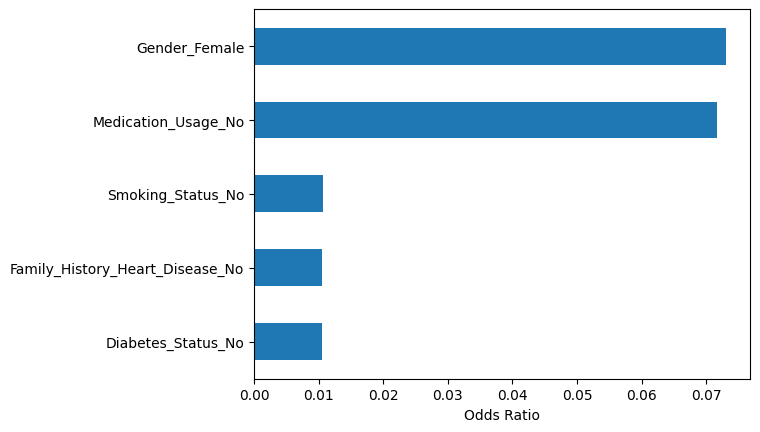

In [30]:
# Plot histogram for odds_ratio
odds_ratio.head().plot(kind = "barh")
plt.xlabel("Odds Ratio")

Text(0.5, 0, 'Odds Ratio')

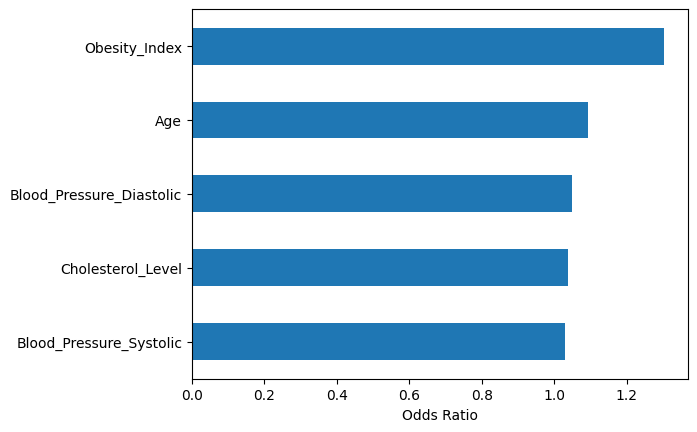

In [59]:
# Plot histogram for odds_ratio
odds_ratio.tail().plot(kind = "barh")
plt.xlabel("Odds Ratio")

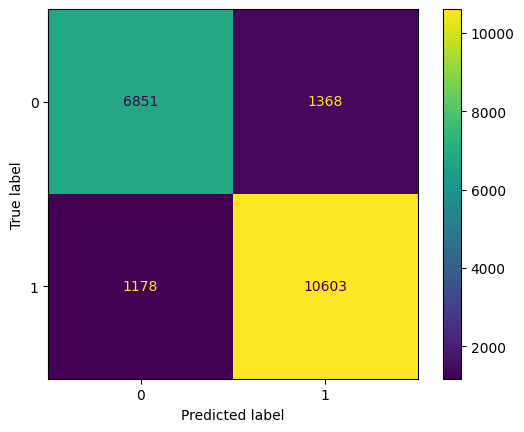

In [67]:
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)